# Download dei dati

I dati sono disponibili al seguente link

https://www.kaggle.com/competitions/data-science-bowl-2018

dopo aver effettuato il login sulla piattaforma Kaggle, nella sezione Data della competizione. Caricate il dataset nel vostro Google Drive.

Potrete sincronizzare l'account di Colab con il vostro Google Drive, seguendo la seguente guida:

https://www.marktechpost.com/2019/06/07/how-to-connect-google-colab-with-google-drive/





# Import necessari e check sulla GPU

In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

torch.manual_seed(42)

cuda


/home/competition/.conda/envs/pytorch_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import dei packages necessari

In [2]:
import os
import sys
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import zipfile
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.morphology import label

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        
seed = 42

# Definizione PATH dei dati

In [3]:
path ='/content/gdrive/MyDrive/'
with zipfile.ZipFile(path + 'stage1_train.zip') as z:
    z.extractall('stage1_train')

with zipfile.ZipFile(path +'stage1_test.zip') as z:
    z.extractall('stage1_test')
    
with zipfile.ZipFile(path + 'stage1_test.zip') as z:
    z.extractall('stage2_test_final')   

In [4]:
TRAIN_PATH = os.path.join(path,'stage1_train/')
TEST_PATH = os.path.join(path,'stage1_test/')
TEST_PATH_2 = os.path.join(path,'stage2_test_final/')

train_files = next(os.walk(TRAIN_PATH))[1]
test_files = next(os.walk(TEST_PATH))[1]
test_files_2 = next(os.walk(TEST_PATH_2))[1]
test_files_final = test_files + test_files_2

# Creazione Training e Test Set

In [5]:
X_train = np.zeros((len(train_files), 128, 128, 3), dtype = np.uint8)
Y_train = np.zeros((len(train_files), 128, 128, 1), dtype = np.bool)
X_test = np.zeros((len(test_files), 128, 128, 3), dtype = np.uint8)
X_test_2 = np.zeros((len(test_files), 128, 128, 3), dtype = np.uint8)

print('Getting training data...')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_files), total = len(train_files)):
    img_path = TRAIN_PATH + id_ + '/images/' + id_ + '.png'
    img = imread(img_path)[:,:,:3]
    img = resize(img, (128, 128), mode='constant', preserve_range=True)
    X_train[n] = img
    
    masks_path = TRAIN_PATH + id_ + '/masks/'
    mask = np.zeros((128, 128, 1))
    mask_images = next(os.walk(masks_path))[2]
    for mask_id in mask_images:
        mask_path = masks_path + mask_id
        mask_ = imread(mask_path)
        mask_ = np.expand_dims(resize(mask_, (128, 128), mode='constant', preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

print('Getting testing data for stage 1...')
sys.stdout.flush()

sizes_test = []
for n, id_ in tqdm(enumerate(test_files), total = len(test_files)):
    img_path = TEST_PATH + id_ + '/images/' + id_ + '.png'
    img = imread(img_path)[:,:,:3]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (128, 128), mode='constant', preserve_range=True)
    X_test[n] = img

print('Getting testing data for stage 2...')
sys.stdout.flush()

sizes_test_2 = []
for n, id_ in tqdm(enumerate(test_files_2), total = len(test_files_2)):
    img_path = TEST_PATH + id_ + '/images/' + id_ + '.png'
    img = imread(img_path)[:,:,:3]
    sizes_test_2.append([img.shape[0], img.shape[1]])
    img = resize(img, (128, 128), mode='constant', preserve_range=True)
    X_test_2[n] = img

print('Done!')

Getting training data...


/tmp/ipykernel_22571/3808188105.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = np.zeros((len(train_files), 128, 128, 1), dtype = np.bool)
100%|██████████| 670/670 [03:14<00:00,  3.45it/s]

Getting testing data for stage 1...



100%|██████████| 65/65 [00:01<00:00, 58.18it/s]

Getting testing data for stage 2...



100%|██████████| 65/65 [00:01<00:00, 57.89it/s]

Done!


In [6]:

#? Lunghezza totale del dataset di test
X_test_final = np.concatenate((X_test, X_test_2), axis = 0)
sizes_test_final = sizes_test + sizes_test_2
print(X_test_final.shape)

(130, 128, 128, 3)


# Definizione del Dataset

In [9]:
class Nuc_Seg(Dataset):
    def __init__(self, images_np, masks_np):
        self.images_np = images_np
        self.masks_np = masks_np
    
    def transform(self, image_np, mask_np):
        ToPILImage = transforms.ToPILImage()
        image = ToPILImage(image_np)
        mask = ToPILImage(mask_np.astype(np.int32))
        
        image = TF.pad(image, padding = 20, padding_mode = 'reflect')
        mask = TF.pad(mask, padding = 20, padding_mode = 'reflect')
        
        angle = random.uniform(-10, 10)
        width, height = image.size
        max_dx = 0.1 * width
        max_dy = 0.1 * height
        translations = (np.round(random.uniform(-max_dx, max_dx)), np.round(random.uniform(-max_dy, max_dy)))
        scale = random.uniform(0.8, 1.2)
        shear = random.uniform(-0.5, 0.5)
        image = TF.affine(image, angle = angle, translate = translations, scale = scale, shear = shear)
        mask = TF.affine(mask, angle = angle, translate = translations, scale = scale, shear = shear)
        
        image = TF.center_crop(image, (128, 128))
        mask = TF.center_crop(mask, (128, 128))
        
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask
        
    def __len__(self):
        return len(self.images_np)
    
    def __getitem__(self, idx):
        image_np = self.images_np[idx]
        mask_np = self.masks_np[idx]
        image, mask = self.transform(image_np, mask_np)
        
        return image, mask 

# Dataloader che usa il Dataset creato

In [10]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state = seed)

train_dataset = Nuc_Seg(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True, drop_last=True)
valid_dataset = Nuc_Seg(X_val, Y_val)
valid_loader = DataLoader(valid_dataset, batch_size = 16, shuffle = True)

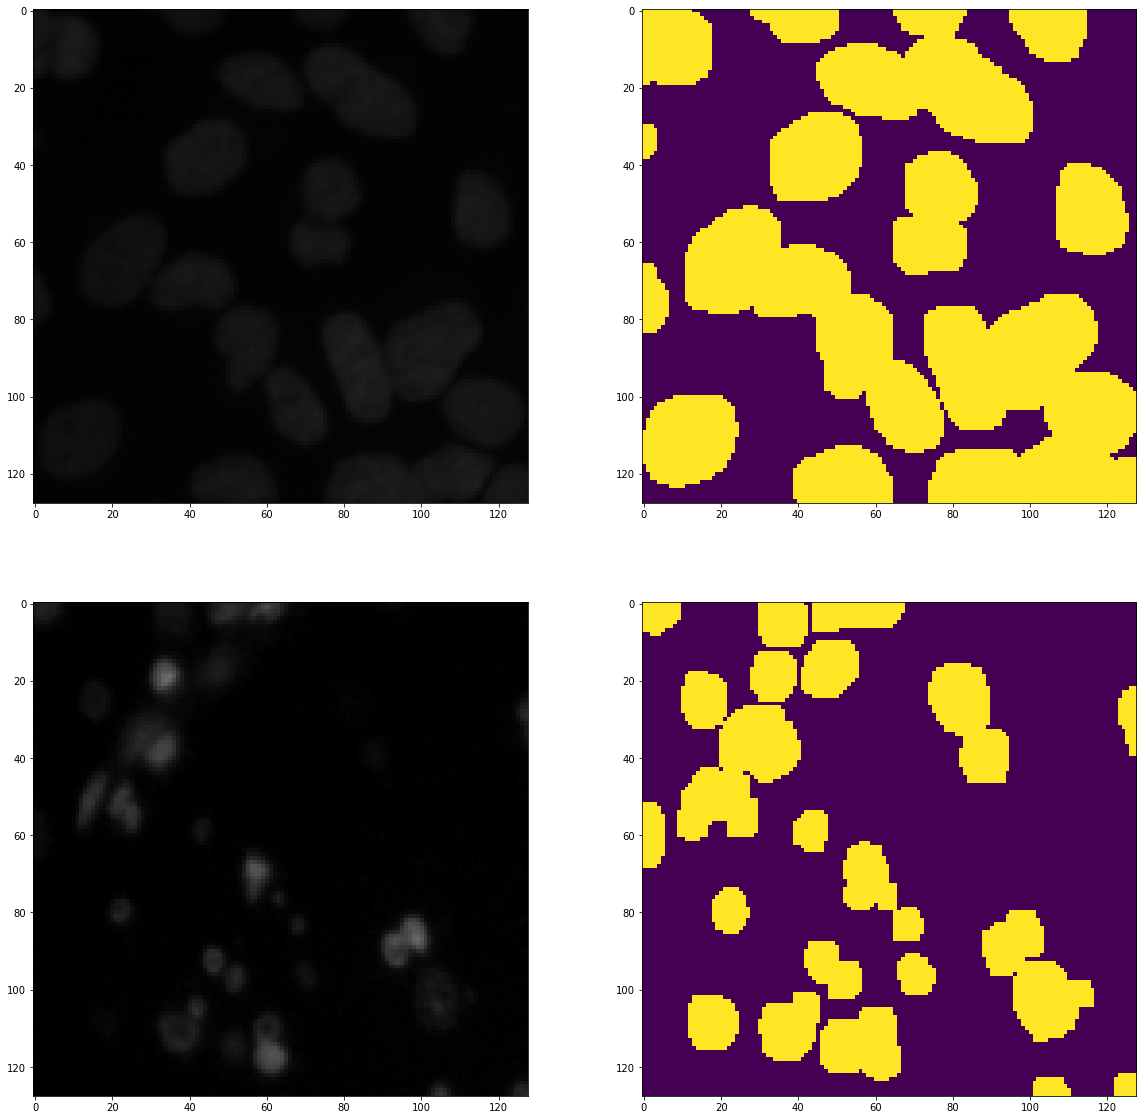

In [11]:

#! Plot immagine esempio

fig, axis = plt.subplots(2, 2, figsize=(20,20))
axis[0][0].imshow(X_train[0].astype(np.uint8))
axis[0][1].imshow(np.squeeze(Y_train[0]).astype(np.uint8))
axis[1][0].imshow(X_val[0].astype(np.uint8))
axis[1][1].imshow(np.squeeze(Y_val[0]).astype(np.uint8))

# IOU (Intersection Over Union) or Jaccard index
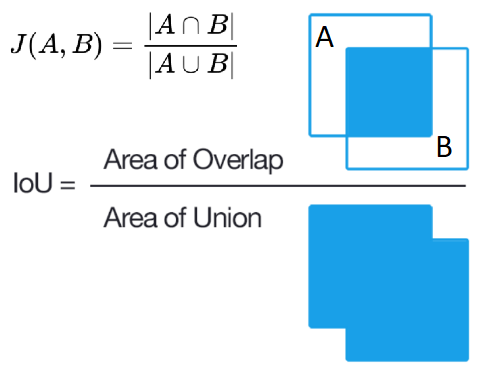

In [12]:
def iou(pred, target, n_classes = 2):
    
    iou = []
    pred = pred.view(-1)
    target = target.view(-1)

    # Ignore IoU for background class ("0")
    for cls in range(1, n_classes):  # This goes from 1:n_classes-1 -> class "0" is ignored
      pred_inds = pred == cls
      target_inds = target == cls
      intersection = (pred_inds[target_inds]).long().sum().data.cpu().item()  # Cast to long to prevent overflows
      union = pred_inds.long().sum().data.cpu().item() + target_inds.long().sum().data.cpu().item() - intersection
    
      if union == 0:
        iou.append(float('nan'))  # If there is no ground truth, do not include in evaluation
      else:
        iou.append(float(intersection) / float(max(union, 1)))
     
    return sum(iou)

In [13]:
def iou_metric(y_pred, y_true, n_classes = 2):
    miou = []
    for i in np.arange(0.5, 1.0, 0.05):
        y_pred_ = (y_pred > i)
        iou_init = iou(y_pred_, y_true, n_classes = n_classes)
        miou.append(iou_init)
    
    return sum(miou)/len(miou)

In [14]:
class UNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1_1 = nn.Conv2d(3, 16, kernel_size = 3, padding = 1)
        self.drop1_1 = nn.Dropout2d(0.1)
        self.conv1_2 = nn.Conv2d(16, 16, kernel_size = 3, padding = 1)
        
        self.conv2_1 = nn.Conv2d(16, 32, kernel_size = 3, padding = 1)
        self.drop2_1 = nn.Dropout2d(0.1)
        self.conv2_2 = nn.Conv2d(32, 32, kernel_size = 3, padding = 1)
        
        self.conv3_1 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        self.drop3_1 = nn.Dropout2d(0.2)
        self.conv3_2 = nn.Conv2d(64, 64, kernel_size = 3, padding = 1)
        
        self.conv4_1 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
        self.drop4_1 = nn.Dropout2d(0.2)
        self.conv4_2 = nn.Conv2d(128, 128, kernel_size = 3, padding = 1)
        
        self.conv5_1 = nn.Conv2d(128, 256, kernel_size = 3, padding = 1)
        self.drop5_1 = nn.Dropout2d(0.3)
        self.conv5_2 = nn.Conv2d(256, 256, kernel_size = 3, padding = 1)
        
        self.conv_trans6_1 = nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = (2, 2))
        self.conv6_1 = nn.Conv2d(256, 128, kernel_size = 3, padding = 1)
        self.drop6_1 = nn.Dropout2d(0.2)
        self.conv6_2 = nn.Conv2d(128, 128, kernel_size = 3, padding = 1)
        
        self.conv_trans7_1 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = (2, 2))
        self.conv7_1 = nn.Conv2d(128, 64, kernel_size = 3, padding = 1)
        self.drop7_1 = nn.Dropout2d(0.2)
        self.conv7_2 = nn.Conv2d(64, 64, kernel_size = 3, padding = 1)
        
        self.conv_trans8_1 = nn.ConvTranspose2d(64, 32, kernel_size = 2, stride = (2, 2))
        self.conv8_1 = nn.Conv2d(64, 32, kernel_size = 3, padding = 1)
        self.drop8_1 = nn.Dropout2d(0.1)
        self.conv8_2 = nn.Conv2d(32, 32, kernel_size = 3, padding = 1)
        
        self.conv_trans9_1 = nn.ConvTranspose2d(32, 16, kernel_size = 2, stride = (2, 2))
        self.conv9_1 = nn.Conv2d(32, 16, kernel_size = 3, padding = 1)
        self.drop9_1 = nn.Dropout2d(0.1)
        self.conv9_2 = nn.Conv2d(16, 16, kernel_size = 3, padding = 1)
        
        self.conv10 = nn.Conv2d(16, 1, kernel_size = 3, padding = 1)
    
    def forward(self, s):
        
        c1 = F.elu(self.conv1_1(s))
        c1 = self.drop1_1(c1)
        c1 = F.elu(self.conv1_2(c1))
        p1 = F.max_pool2d(c1, kernel_size = (2, 2), stride = 2)
        
        c2 = F.elu(self.conv2_1(p1))
        c2 = self.drop2_1(c2)
        c2 = F.elu(self.conv2_2(c2))
        p2 = F.max_pool2d(c2, kernel_size = (2, 2), stride = 2)
        
        c3 = F.elu(self.conv3_1(p2))
        c3 = self.drop3_1(c3)
        c3 = F.elu(self.conv3_2(c3))
        p3 = F.max_pool2d(c3, kernel_size = (2, 2), stride = 2)
        
        c4 = F.elu(self.conv4_1(p3))
        c4 = self.drop4_1(c4)
        c4 = F.elu(self.conv4_2(c4))
        p4 = F.max_pool2d(c4, kernel_size = (2, 2), stride = 2)
        
        c5 = F.elu(self.conv5_1(p4))
        c5 = self.drop5_1(c5)
        c5 = F.elu(self.conv5_2(c5))
        
        u6 = self.conv_trans6_1(c5)
        u6 = torch.cat((u6, c4), axis = 1)
        c6 = F.elu(self.conv6_1(u6))
        c6 = self.drop6_1(c6)
        c6 = F.elu(self.conv6_2(c6))
        
        u7 = self.conv_trans7_1(c6)
        u7 = torch.cat((u7, c3), axis = 1)
        c7 = F.elu(self.conv7_1(u7))
        c7 = self.drop7_1(c7)
        c7 = F.elu(self.conv7_2(c7))
    
        u8 = self.conv_trans8_1(c7)
        u8 = torch.cat((u8, c2), axis = 1)
        c8 = F.elu(self.conv8_1(u8))
        c8 = self.drop8_1(c8)
        c8 = F.elu(self.conv8_2(c8))
        
        u9 = self.conv_trans9_1(c8)
        u9 = torch.cat((u9, c1), axis = 1)
        c9 = F.elu(self.conv9_1(u9))
        c9 = self.drop9_1(c9)
        c9 = F.elu(self.conv9_2(c9))
        
        output = torch.sigmoid(self.conv10(c9))
        
        return output

In [15]:
model = UNet()
model = model.float()
model = model.to(device)
print(model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Numbers of params:', total_params)

UNet(
  (conv1_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (drop1_1): Dropout2d(p=0.1, inplace=False)
  (conv1_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (drop2_1): Dropout2d(p=0.1, inplace=False)
  (conv2_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (drop3_1): Dropout2d(p=0.2, inplace=False)
  (conv3_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (drop4_1): Dropout2d(p=0.2, inplace=False)
  (conv4_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (drop5_1): Dropout2d(p=0.3, inplace=False)
  (conv5_2): Conv2d(256, 256, kernel_size=(3, 3), stri

In [16]:
opt = optim.Adam(model.parameters(), lr = 0.001)
loss_func = nn.BCELoss()
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, patience = 3, verbose = 1)

# Fase di addestramento

In [17]:
def fit(model, epochs, opt, loss_func, train_loader, valid_loader, alpha):
    training_loss, validation_loss, train_iou, validation_iou = [], [], [], []
    for epoch in range(epochs):
        
        #Going into training mode
        model.train()
        
        train_loss = 0 
        iou = 0
        
        for image, mask in train_loader:
            image = image.to(device)   #Passing the input mini-batch to the GPU
            mask = mask.to(device)   #Passing the label mini-batch to the GPU
            opt.zero_grad()      #Setting the grads to zero to avoid accumulation of gradients
            out = model(image.float())
            loss = loss_func(out.float(), mask.float())    
            train_loss += loss
            
            iou += iou_metric(out, mask)
            iou_rev = 16 - iou_metric(out, mask)
            loss += alpha * iou_rev
            
            loss.backward()
            opt.step()
        
        lr_scheduler.step(train_loss/len(train_loader))   #Setting up lr decay  
        
        model.eval()            #Going into eval mode                            
        with torch.no_grad():   #No backprop
            valid_loss = 0
            valid_iou = 0
            
            for image_val, mask_val in valid_loader:
                image_val = image_val.to(device)  
                mask_val = mask_val.to(device)
                out_val = model(image_val.float())
                valid_loss += loss_func(out_val.float(), mask_val.float())
                
                valid_iou += iou_metric(out_val, mask_val)
        
        print("Epoch ", epoch + 1, " Training Loss: ", train_loss.item()/len(train_loader), "CV Loss: ", valid_loss.item()/len(valid_loader))
        print("Training IoU: ", iou/len(train_loader), "CV IoU: ", valid_iou/len(valid_loader))
        training_loss.append(train_loss.item()/len(train_loader))
        validation_loss.append(valid_loss.item()/len(valid_loader))
        train_iou.append(iou/len(train_loader))
        validation_iou.append(valid_iou/len(valid_loader))
    return training_loss, validation_loss, train_iou, validation_iou

In [18]:
train_loss, valid_loss, train_iou, valid_iou = fit(model, 40, opt, loss_func, train_loader, valid_loader, 5)

Epoch  1  Training Loss:  0.5841135545210405 CV Loss:  0.5392823219299316
Training IoU:  0.0006447716218150618 CV IoU:  0.0
Epoch  2  Training Loss:  0.5302841880104758 CV Loss:  0.4994955062866211
Training IoU:  0.017016290575622903 CV IoU:  0.033901637299631505
Epoch  3  Training Loss:  0.4322335214325876 CV Loss:  0.34073591232299805
Training IoU:  0.21294109797568894 CV IoU:  0.37584370032387837
Epoch  4  Training Loss:  0.35899520642829663 CV Loss:  0.26173463463783264
Training IoU:  0.35445878247156243 CV IoU:  0.4004304876923257
Epoch  5  Training Loss:  0.3164664181795987 CV Loss:  0.2532477378845215
Training IoU:  0.5024103251931636 CV IoU:  0.4895548952601405
Epoch  6  Training Loss:  0.2848333011973988 CV Loss:  0.22688709199428558
Training IoU:  0.4869333877151406 CV IoU:  0.5401092857559568
Epoch  7  Training Loss:  0.2571021282311642 CV Loss:  0.22588711977005005
Training IoU:  0.5383651406882464 CV IoU:  0.4636831422579283
Epoch  8  Training Loss:  0.23427365042946555 CV

# Risultati ottenuti

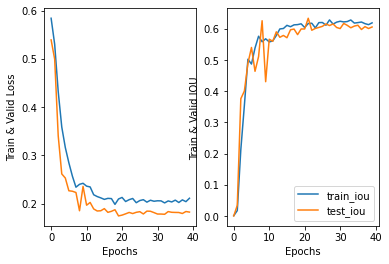

In [19]:
fig, axs= plt.subplots(nrows=1, ncols=2)
axs[0].plot([i for i in range(len(train_loss))], train_loss, label='train_loss')
axs[0].plot([i for i in range(len(valid_loss))], valid_loss, label='test_loss')
axs[1].plot([i for i in range(len(train_iou))], train_iou, label='train_iou')
axs[1].plot([i for i in range(len(valid_iou))], valid_iou, label='test_iou')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Train & Valid Loss")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Train & Valid IOU")
plt.legend(loc="best")
plt.show()

# Plot delle predizioni

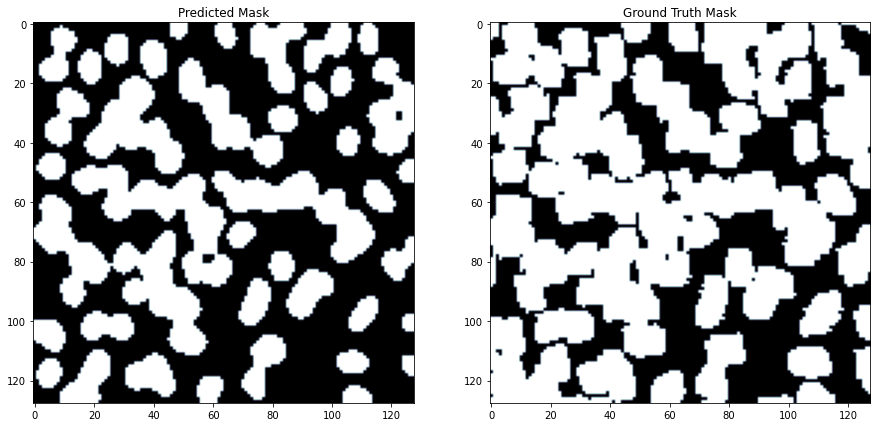

In [20]:
%matplotlib inline

for ex_img, ex_mask in train_loader:
    
    img = ex_img[1].to(device)
    img.unsqueeze_(0)
    mask_pred = model(img.float())
    mask_pred = mask_pred.cpu()
    mask_pred = (mask_pred > 0.75)
    mask_true = ex_mask[1]
    
    img = TF.to_pil_image(mask_pred.float().squeeze(0))
    mask = TF.to_pil_image(mask_true)
    
    img = np.array(img)
    mask = np.array(mask)
    
    fig, (axis_1, axis_2) = plt.subplots(1, 2, figsize=(15, 15))
    axis_1.imshow(img.astype(np.uint8), cmap='bone')
    axis_1.set_title('Predicted Mask')
    axis_2.imshow(mask.astype(np.uint8), cmap='bone')
    axis_2.set_title('Ground Truth Mask')
    
    break

In [ ]:
with torch.no_grad():
    
    test = torch.from_numpy(X_test)
    test = test/255.0
    test = test.permute(0, 3, 1, 2)
    test = test.to(device)
    preds = model(test.float())
    preds = preds.permute(0, 2, 3, 1) 
    print(preds.shape)

    preds = preds*255.0
    preds = preds.cpu().numpy()

print(preds.shape)